# Expectation maximization algorithm for a Gaussian mixture model

To compute a maximum likelihood fit for a mixture of Gaussians model of the Old Faithful dataset using the expectation maximization algorithm.

The likelihood for a mixture model is defined as: $p(x_i|\theta) = \sum_k p(x_i, z_i = k | \theta) = \sum_k p(x_i| z_i = k, \theta) p(z_i=k|\theta) $ where $x_i$ is the feature vector of the $i$th data point, $z_i$ is a latent (unobserved) variable and $\theta$ is a parameter vector. $k$ is an index which labels each base distribution, $k=1,\dots,K$. 

For a Gaussian mixture model, each 'base distribution' $p(x_i| z_i = k, \theta) = \mathcal{N}(\mu_k,\Sigma_k)$, where $\mu_k$ is the mean and $\Sigma_k$ is the covariance matrix of each multivariate Gaussian in the mixture model.

Based on Ch11 of Machine Learning: A Probabilistic Perspective (Kevin Murphy)

Author: Juvid Aryaman


In [1]:
import numpy as np
import pandas as pd
import utls
from os.path import join
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
utls.reset_plots()

In [3]:
from scipy.stats import multivariate_normal

## Import and transform data

In [4]:
data_dir = '../Data/'

In [5]:
data = pd.read_csv(join(data_dir,'faithful.csv'), delimiter=',')
data.columns=['d','w']

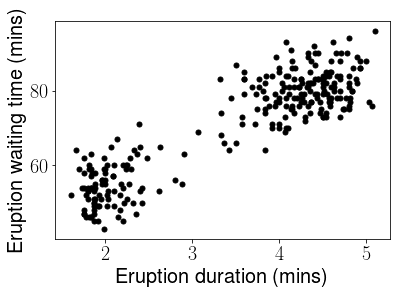

In [6]:
fig, ax = plt.subplots(1,1)
ax.plot(data['d'],data['w'],'.k');
ax.set_xlabel('Eruption duration (mins)');
ax.set_ylabel('Eruption waiting time (mins)');

The data clearly shows the existence of two clusters (bottom left and top right), so we will use $K=2$. Our aim is to model the data as a mixture of two bivariate Gaussians, where every data point $x_i$ possesses a latent variable $z_i$ which is the identity of the Gaussian which it belongs to. We will seek a maximum-likelihood fit.

First, we normalize the data. In practice, this improves the convergence of the algorithm.

In [7]:
# z-transform data
data['d'] = (data['d'] - data['d'].mean())/data['d'].std(ddof=1)
data['w'] = (data['w'] - data['w'].mean())/data['w'].std(ddof=1)
data.head()

,d,w
0,0.098318,0.596025
1,-1.478733,-1.242890
2,-0.135612,0.228242
3,-1.055558,-0.654437
4,0.915755,1.037364


## Definitions for the EM algorithm

The EM algorithm proceeds in two steps. Let $l_c(\theta) = \sum_{i=1}^N \log p( x_i, z_i| \theta)$ be the likelihood of observing the data *and* the latent variables: this is called the 'complete data log likelihood'.

1. Compute the (sufficient statistics of) the mean of $l_c(\theta)$ over the latent variables $z$, assuming values of $\theta$ at the previous time step. Call this $Q(\theta,\theta^{t-1}) = \mathbb{E}_{z|x,\theta^{t-1}}[l_c(\theta)|\mathcal{D},\theta^{t-1}]$
2. Optimize the value of $Q(\theta,\theta^{t-1})$ with respect to $\theta$

Repeat until convergence.

It turns out that for (1), the sufficient statistic of $Q(\theta,\theta^{t-1})$ is called the **responsibility**

$$r_{ik}:=p(z_i=k|x_i,\theta^{t-1}) = \frac{\pi_k p(x_i|z_i=k,\theta_k^{t-1})}{\sum_{k'}\pi_{k'}p(x_i|z_i=k',\theta_{k'}^{t-1})}$$

where $\pi_k=p(z_i=k|\theta)$ is the mixing weight. $r_{ik}$ is simply the probability that data point $i$ is in cluster $k$.

In [8]:
def compute_expected_sufficient_statistic(data,params):
    """
    Compute the responsibility cluster k takes for each data point
    """
    
    lik0 = multivariate_normal.pdf(data,mean=params['mu0'], cov=params['sig0'])
    lik1 = multivariate_normal.pdf(data,mean=params['mu1'], cov=params['sig1'])
    
    rik=np.array(zip(lik0, lik1))

    den = rik[:,0]*params['pi0'] + rik[:,1]*params['pi1']

    rik[:,0] = rik[:,0]*params['pi0']/den
    rik[:,1] = rik[:,1]*params['pi1']/den
    
    return rik # weighted probability data point xi belongs to cluster k
    
    

In [9]:
def elementwise_mean(row, k, rik):
    i = row.name
    xi = row.values
    m = rik[i,k] * xi
    return pd.Series({'m0':m[0],
                     'm1':m[1]})

In [10]:
def elementwise_cov(row, k, rik):
    i = row.name
    xi = row.values
    cov = rik[i,k] * np.outer(xi,xi)
    return pd.Series({'e0':cov[0,0],
                     'e1':cov[0,1],
                     'e2':cov[1,0],
                     'e3':cov[1,1]})
    

## Perform Expectation Maximization

In [11]:
# Initialise parameter guess
c_guess = np.eye(2)
params = {'pi0':0.5,'pi1':0.5,'mu0':np.array([-1,1]),'mu1':np.array([1,-1]),'sig0':c_guess,'sig1':c_guess}

params_ic = params.copy()

In [12]:
N = len(data)

In [13]:
n_iter = 50

In [14]:
rik_all = np.zeros((len(data),2,n_iter))
for i in range(n_iter):
    
    if i % 10 == 0:
        print(i)
    
    # 1. Expectation
    # Compute expected sufficient statistics
    # i.e. probability data point i is in cluster k given parameters

    rik = compute_expected_sufficient_statistic(data,params) # (data index, probabilities)
    rik_all[:,:,i] = rik
    
    # 2. Maximization
    # Optimize expected complete data log likelihood w.r.t. parameters
    rk = rik.sum(axis=0) # sum over data (rows)
    
    params['pi0'] = np.sum(rik[:,0])/N
    params['pi1'] = np.sum(rik[:,1])/N 
    
    for k in range(2): # clusters
        # Use formulae from p353 of Murphy
        # Means
        means = data.apply(lambda x: elementwise_mean(x,k,rik), axis = 1).sum(axis=0)/rk[k]
        means =  means.as_matrix()
        params['mu{}'.format(k)] = means
        
        # Covariances
        covs = data.apply(lambda x: elementwise_cov(x,k,rik), axis = 1) # apply to each row
        cov_elements = covs.sum(axis=0).values.reshape((2,2))/rk[k] - np.outer(means, means)
        params['sig{}'.format(k)] = cov_elements
    
    
    

0
10
20
30
40


In [15]:
cmap = plt.cm.coolwarm

Plot the data colored by the probability that they belong to a particular cluster

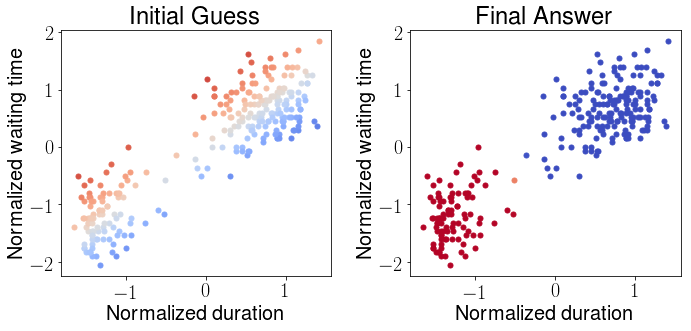

In [16]:
rik_orig = compute_expected_sufficient_statistic(data,params_ic)

fig,axs = plt.subplots(1,2, figsize=(2*5,5))

ax = axs[0]
for row in data.iterrows():
    i = row[0]
    d = row[1]
    ax.plot(d['d'],d['w'],'.',color=cmap(int(round(rik_orig[i,0]*cmap.N))))
ax.set_title('Initial Guess');
ax.set_xlabel('Normalized duration');
ax.set_ylabel('Normalized waiting time');

ax = axs[1]
for row in data.iterrows():
    i = row[0]
    d = row[1]
    ax.plot(d['d'],d['w'],'.',color=cmap(int(round(rik[i,0]*cmap.N))))
ax.set_title('Final Answer');
ax.set_xlabel('Normalized duration');
ax.set_ylabel('Normalized waiting time');

plt.tight_layout()